In [2]:
import requests
from accesstoken import access_token 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, f_oneway, chi2_contingency

# Spotify API endpoint for new releases
NEW_RELEASES_URL = "https://api.spotify.com/v1/browse/new-releases"
ARTIST_URL = "https://api.spotify.com/v1/artists/"
ALBUMS_URL = "https://api.spotify.com/v1/artists/{artist_id}/albums"
TRACKS_URL = "https://api.spotify.com/v1/albums/{album_id}/tracks"
Individual_TRACK_URL = "https://api.spotify.com/v1/tracks/{id}"
TRACK_FEATURES_URL = "https://api.spotify.com/v1/audio-features/{track_id}"


In [3]:
# Function to get new releases
def get_new_releases(access_token, limit=50):
    headers = {'Authorization': f'Bearer {access_token}'}
    params = {'limit': limit}
    response = requests.get(NEW_RELEASES_URL, headers=headers, params=params)
    return response.json()

In [4]:
# Function to extract artists from new releases

def extract_artists(new_releases_data):
    artist_info = []
    for album in new_releases_data['albums']['items']:
        for artist in album['artists']:
            artist_info.append({'name': artist['name'], 'id': artist['id']})  # Append dictionaries to the list
    return artist_info


In [5]:

# Main function to find popular artists from new releases
def find_popular_artists(limit=50):
    new_releases_data = get_new_releases(access_token, limit)
    artists = extract_artists(new_releases_data)
    for artist in artists:
        artist['popularity'] = get_artist_popularity(artist['id'], access_token)
    return artists


In [6]:
# Function to get the popularity of an artist

def get_artist_popularity(artist_id, access_token):
    artist_url = ARTIST_URL + artist_id
    headers = {'Authorization': f'Bearer {access_token}'}
    response = requests.get(artist_url, headers=headers)
    if response.status_code == 200:
        return response.json()['popularity']
    else:
        return None


In [7]:

def find_most_popular_artist(artists):
    most_popular_artist = None
    max_popularity = -1
    for artist in artists:
        if artist['popularity'] is not None and artist['popularity'] > max_popularity:
            most_popular_artist = artist
            max_popularity = artist['popularity']
    return most_popular_artist
    

In [8]:
# Function to get an artist's albums
def get_artist_albums(artist_id, access_token):
    albums_url = ALBUMS_URL.format(artist_id=artist_id)
    headers = {'Authorization': f'Bearer {access_token}'}
    response = requests.get(albums_url, headers=headers)
    if response.status_code == 200:
        return response.json()['items']
    else:
        return None

In [9]:
# Function to get an album's tracks
def get_album_tracks(album_id, access_token):
    tracks_url = TRACKS_URL.format(album_id=album_id)
    headers = {'Authorization': f'Bearer {access_token}'}
    response = requests.get(tracks_url, headers=headers)
    if response.status_code == 200:
        return response.json()['items']
    else:
        return None

In [10]:
# Function to find the most popular artist's album and its track features
def find_most_popular_album_and_tracks(most_popular_artist, access_token):
    artist_albums = get_artist_albums(most_popular_artist['id'], access_token)
    if artist_albums:
        most_popular_album = artist_albums[0]  # Assuming the first album is the most popular
        album_id = most_popular_album['id']
        album_tracks = get_album_tracks(album_id, access_token)
        if album_tracks:
            tracks_with_features = []
            for track in album_tracks:
                track_features = get_track_features(track['id'], access_token)
                if track_features:
                    track['features'] = track_features
                    track['popularity'] = get_track_popularity(track['id'], access_token)  # Add track popularity
                    tracks_with_features.append(track)
            return most_popular_album, tracks_with_features
        else:
            return most_popular_album, None
    else:
        return None, None
# Function to get track features
def get_track_features(track_id, access_token):
    track_features_url = TRACK_FEATURES_URL.format(track_id=track_id)
    headers = {'Authorization': f'Bearer {access_token}'}
    response = requests.get(track_features_url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        return None     

In [ ]:
# Function to get track popularity
def get_track_popularity(track_id, access_token):
    individual_track_url = Individual_TRACK_URL.format(id=track_id)
    headers = {'Authorization': f'Bearer {access_token}'}
    response = requests.get(individual_track_url, headers=headers)
    if response.status_code == 200:
        return response.json()['popularity']
    else:
        return None


In [30]:
        
popular_artists = find_popular_artists()
popular_artists_df= pd.DataFrame(popular_artists)
print(popular_artists_df)


                 name                      id  popularity
0             J. Cole  6l3HvQ5sa6mXTsMTB19rO5          88
1              Sum 41  0qT79UgT5tY4yudH9VfsdT          74
2       Kenny Chesney  3grHWM9bx2E9vwJCdlRv9O          72
3             Beyoncé  6vWDO969PvNqNYHIOW5v0m          92
4           Logic1000  2EFsfh1zewsSWhDINv7j1I          50
5         Waxahatchee  5IWCU0V9evBlW4gIeGY4zF          61
6      West Thebarton  6ZQNx5JnPy6CmVur8jRPrv          29
7                Tyla  3SozjO3Lat463tQICI9LcE          80
8       The Veronicas  1dIdBZaaHRW2bDTkHNfWln          56
9      Kita Alexander  3CGuwWgoCYSO5Z72H5G2Ec          61
10         Blake Rose  7wLyGTO9vUS7ndlq4BvBGe          52
11      Ariana Grande  66CXWjxzNUsdJxJ2JdwvnR          95
12        Norah Jones  2Kx7MNY7cI1ENniW7vT30N          74
13       Lane Pittman  4amB7X5ESMq5PB1ve3HmYZ          35
14          Bleachers  2eam0iDomRHGBypaDQLwWI          70
15     Dillon Francis  5R3Hr2cnCCjt220Jmt2xLf          63
16   Good Time

In [31]:
most_popular_artist = find_most_popular_artist(popular_artists)
if most_popular_artist:
    print("Most popular artist:", most_popular_artist['name'], "with popularity:", most_popular_artist['popularity'])
else:
    print("No popular artists found.")


Most popular artist: Ariana Grande with popularity: 95


In [32]:

if most_popular_artist:
    print("Most popular artist:", most_popular_artist['name'])
    most_popular_album, album_tracks = find_most_popular_album_and_tracks(most_popular_artist, access_token)
    if most_popular_album:
        print("Most popular album:", most_popular_album['name'])
        print("Album tracks:")        
        for track in album_tracks:
            print("- Track name:", track['name'])
            print("  Track duration:", track['duration_ms'], "ms")
            print("  Track ID:", track['id'])
            print("  Track features:", track['features']) 
            print("  Track popularity:", track['popularity'])           
    else:
        print("No albums found for the most popular artist.")
else:
    print("No popular artists found.")


Most popular artist: Ariana Grande
Most popular album: eternal sunshine (slightly deluxe)
Album tracks:
- Track name: intro (end of the world)
  Track duration: 92400 ms
  Track ID: 7xTbVQSuLpM1SRIKMcaPCI
  Track features: {'danceability': 0.475, 'energy': 0.37, 'key': 10, 'loudness': -9.471, 'mode': 1, 'speechiness': 0.0517, 'acousticness': 0.64, 'instrumentalness': 0, 'liveness': 0.176, 'valence': 0.354, 'tempo': 83.84, 'type': 'audio_features', 'id': '7xTbVQSuLpM1SRIKMcaPCI', 'uri': 'spotify:track:7xTbVQSuLpM1SRIKMcaPCI', 'track_href': 'https://api.spotify.com/v1/tracks/7xTbVQSuLpM1SRIKMcaPCI', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7xTbVQSuLpM1SRIKMcaPCI', 'duration_ms': 92400, 'time_signature': 4}
  Track popularity: 75
- Track name: bye
  Track duration: 164927 ms
  Track ID: 7aOgyKhHxAhrzTKkLGF3Ha
  Track features: {'danceability': 0.64, 'energy': 0.662, 'key': 2, 'loudness': -4.856, 'mode': 0, 'speechiness': 0.0308, 'acousticness': 0.209, 'instrumentalness':

In [25]:
# Extract track features and popularity
track_features_list = []
track_popularity_list = []
for track in album_tracks:
    if track['features'] and track['popularity'] is not None:  # Check if features and popularity are available
        track_features_list.append(track['features'])
        track_popularity_list.append(track['popularity'])

# Convert lists to DataFrame for analysis
track_features_df = pd.DataFrame(track_features_list)
track_popularity_df = pd.DataFrame({'popularity': track_popularity_list})

# Concatenate track features and popularity DataFrames
album_data = pd.concat([track_features_df, track_popularity_df], axis=1)

# Drop non-numeric columns
album_data_numeric = album_data.select_dtypes(include='number')

print(album_data_numeric.to_string())

    danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo  duration_ms  time_signature  popularity
0          0.475   0.370   10    -9.471     1       0.0517        0.6400          0.000000    0.1760    0.354   83.840        92400               4          75
1          0.640   0.662    2    -4.856     0       0.0308        0.2090          0.000000    0.1550    0.436  110.027       164927               4          74
2          0.512   0.729    9    -5.224     0       0.2100        0.4280          0.000000    0.1130    0.532  129.268       174006               5          74
3          0.554   0.364    9   -13.442     1       0.1510        0.9000          0.000311    0.1450    0.916  121.389        42167               5          71
4          0.658   0.503    9    -6.885     1       0.1020        0.5470          0.000000    0.1170    0.315  159.934       210200               4          75
5          0.591   0.708    8    -6.840 

In [14]:
# Calculate correlations between album popularity and track features
correlations = album_data_numeric.corr()['popularity'].drop('popularity')

# Print correlations
print("Correlation between album popularity and track features:")
print(correlations)


Correlation between album popularity and track features:
danceability       -0.188159
energy              0.314878
key                 0.041741
loudness            0.241700
mode                0.044686
speechiness         0.151396
acousticness       -0.521137
instrumentalness   -0.214520
liveness           -0.206848
valence            -0.412345
tempo              -0.136153
duration_ms         0.115192
time_signature      0.264364
Name: popularity, dtype: float64


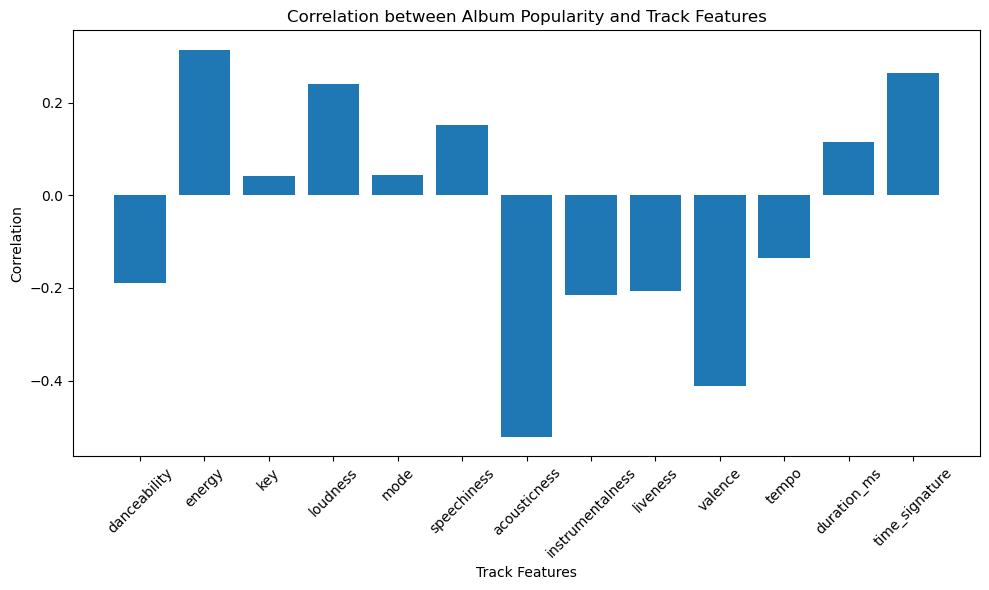

In [15]:
# Visualize the correlations
plt.figure(figsize=(10, 6))
plt.bar(correlations.index, correlations.values)
plt.title("Correlation between Album Popularity and Track Features")
plt.xlabel("Track Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

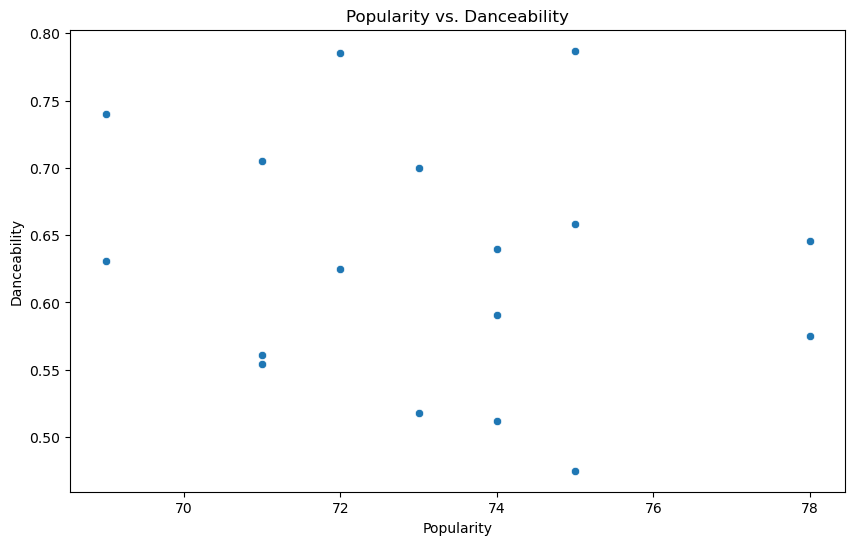

In [16]:
# Scatter plot of popularity vs. danceability
plt.figure(figsize=(10, 6))
sns.scatterplot(data=album_data, x='popularity', y='danceability')
plt.title("Popularity vs. Danceability")
plt.xlabel("Popularity")
plt.ylabel("Danceability")
plt.show()


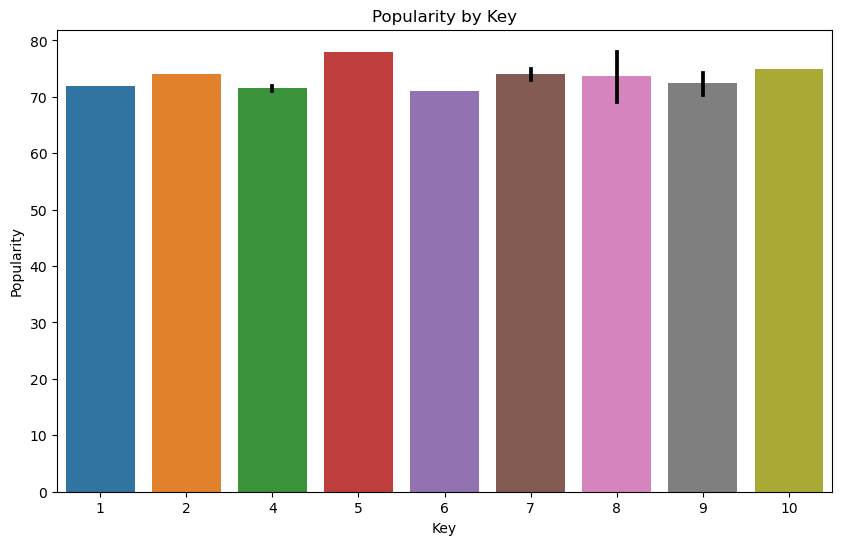

In [23]:
# Bar chart of popularity by key
plt.figure(figsize=(10, 6))
sns.barplot(data=album_data, x='key', y='popularity', errcolor='black')
plt.title("Popularity by Key")
plt.xlabel("Key")
plt.ylabel("Popularity")
plt.show()


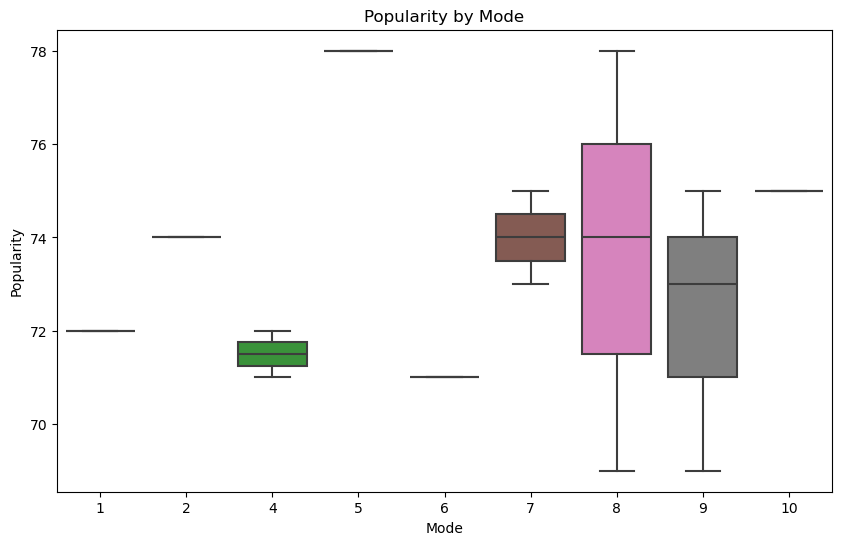

In [35]:
# Box plot of popularity by mode
plt.figure(figsize=(10, 6))
sns.boxplot(data=album_data, x='key', y='popularity')
plt.title("Popularity by Mode")
plt.xlabel("Mode")
plt.ylabel("Popularity")
plt.show()

In [19]:
# Extract popularity and danceability data
popularity_data = album_data['popularity']
danceability_data = album_data['danceability']

# Perform Pearson correlation coefficient and p-value calculation
correlation_coefficient, p_value = pearsonr(popularity_data, danceability_data)

# Define significance level (alpha)
alpha = 0.05

# Print the results
print("Pearson correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)

# Interpret the results
if p_value < alpha:
    print("The correlation between album popularity and danceability is statistically significant.")
else:
    print("There is no statistically significant correlation between album popularity and danceability.")


Pearson correlation coefficient: -0.188159192025604
P-value: 0.4695528879078038
There is no statistically significant correlation between album popularity and danceability.


In [20]:
# T-test comparing popularity of albums with high danceability vs. low danceability
high_danceability = album_data[album_data['danceability'] >= 0.5]['popularity']
low_danceability = album_data[album_data['danceability'] < 0.5]['popularity']

t_statistic, p_value_ttest = ttest_ind(high_danceability, low_danceability)

# Print T-test results
print("T-test results:")
print("T-statistic:", t_statistic)
print("P-value:", p_value_ttest)

# Define significance level (alpha) for T-test
alpha_ttest = 0.05

# Interpret T-test results
if p_value_ttest < alpha_ttest:
    print("There is a statistically significant difference in popularity between albums with high and low danceability.")
else:
    print("There is no statistically significant difference in popularity between albums with high and low danceability.")



T-test results:
T-statistic: -0.7039760073046946
P-value: 0.49223252132612316
There is no statistically significant difference in popularity between albums with high and low danceability.


In [21]:
# ANOVA comparing popularity of albums across different keys
popularity_by_key = [album_data[album_data['key'] == key]['popularity'] for key in album_data['key'].unique()]

f_statistic, p_value_anova = f_oneway(*popularity_by_key)

# Print ANOVA results
print("\nANOVA results:")
print("F-statistic:", f_statistic)
print("P-value:", p_value_anova)

# Define significance level (alpha) for ANOVA
alpha_anova = 0.05

# Interpret ANOVA results
if p_value_anova < alpha_anova:
    print("There is a statistically significant difference in popularity across different keys.")
else:
    print("There is no statistically significant difference in popularity across different keys.")


ANOVA results:
F-statistic: 0.664549295358525
P-value: 0.71168369962913
There is no statistically significant difference in popularity across different keys.


In [22]:
# Create a contingency table for Chi-square test (key vs. mode)
contingency_table = pd.crosstab(album_data['key'], album_data['mode'])

chi2_statistic, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

# Print Chi-square test results
print("\nChi-square test results:")
print("Chi-square statistic:", chi2_statistic)
print("P-value:", p_value_chi2)

# Define significance level (alpha) for Chi-square test
alpha_chi2 = 0.05

# Interpret Chi-square test results
if p_value_chi2 < alpha_chi2:
    print("There is a statistically significant association between key and mode.")
else:
    print("There is no statistically significant association between key and mode.")




Chi-square test results:
Chi-square statistic: 8.811666666666667
P-value: 0.35843193469369455
There is no statistically significant association between key and mode.
